In [532]:
from datetime import datetime
import pandas as pd
import os
import dateutil.parser as date_parser
import matplotlib.pyplot as plt
from typing import Any
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.arima import arima_string
import itertools

## Load timeseries ticker data
### There are 3 tickers analysis is based on:
- S&P 500
- VIX - Volatility index
- US Treasury bonds
- DJIA - Dow Jones Industrial Average

The analysis period is from 2000 to 2024

In [565]:
snp_path = os.path.join(os.getcwd(), 'assets', 's&p500_max.csv')
vix_path = os.path.join(os.getcwd(), 'assets', 'vix_max.csv')
bonds_path = os.path.join(os.getcwd(), 'assets', 'us_bonds_max.csv')
djia_path = os.path.join(os.getcwd(), 'assets', 'djia.csv')

snp_data = pd.read_csv(snp_path, index_col='date', parse_dates=True)
vix_data = pd.read_csv(vix_path, index_col='date', parse_dates=True)
bonds_data = pd.read_csv(bonds_path, index_col='date', parse_dates=True)
djia_data = pd.read_csv(djia_path, index_col='date', parse_dates=True)

start_date = '2000-01-01'
end_date = '2024-01-01'

snp_data = snp_data.loc[start_date:end_date]
# vix_data = vix_data.loc[start_date:end_date]
bonds_data = bonds_data.loc[start_date:end_date]
djia_data = djia_data.loc[start_date:end_date]

# expected business days frequency. Input dataset might have some missing
frequency = 'B'
full_b_days = pd.date_range(start=snp_data.index.min(), end=snp_data.index.max(), freq=frequency)

# common_index = pd.DatetimeIndex(common_index, freq='B')

snp_data = snp_data.reindex(full_b_days)
vix_data = vix_data.reindex(full_b_days)
bonds_data = bonds_data.reindex(full_b_days)
djia_data = djia_data.reindex(full_b_days)
snp_data['close'] = snp_data['close'].interpolate(method='linear')
vix_data['close'] = vix_data['close'].interpolate(method='linear')
bonds_data['close'] = bonds_data['close'].interpolate(method='linear')
djia_data['close'] = djia_data['close'].interpolate(method='linear')

missing_days = full_b_days.difference(snp_data.index)

assert len(missing_days) == 0

### S&P 500

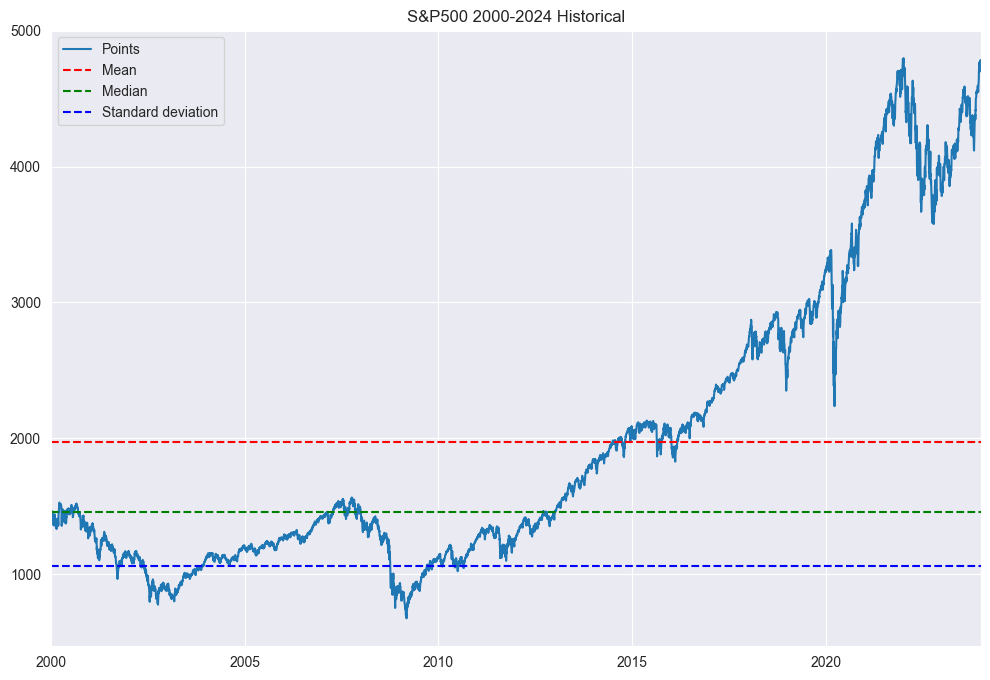

In [566]:
snp_plot = snp_data.plot(title='S&P500 2000-2024 Historical', y='close', label='Points', figsize=(12, 8))
snp_mean = snp_data['close'].mean()
snp_median = snp_data['close'].median()
snp_std = snp_data['close'].std()

snp_plot.axhline(y=snp_mean, label='Mean', color='r', linestyle='dashed')
snp_plot.axhline(y=snp_median, label='Median', color='g', linestyle='dashed')
snp_plot.axhline(y=snp_std, label='Standard deviation', color='b', linestyle='dashed')

snp_plot.legend()

### VIX

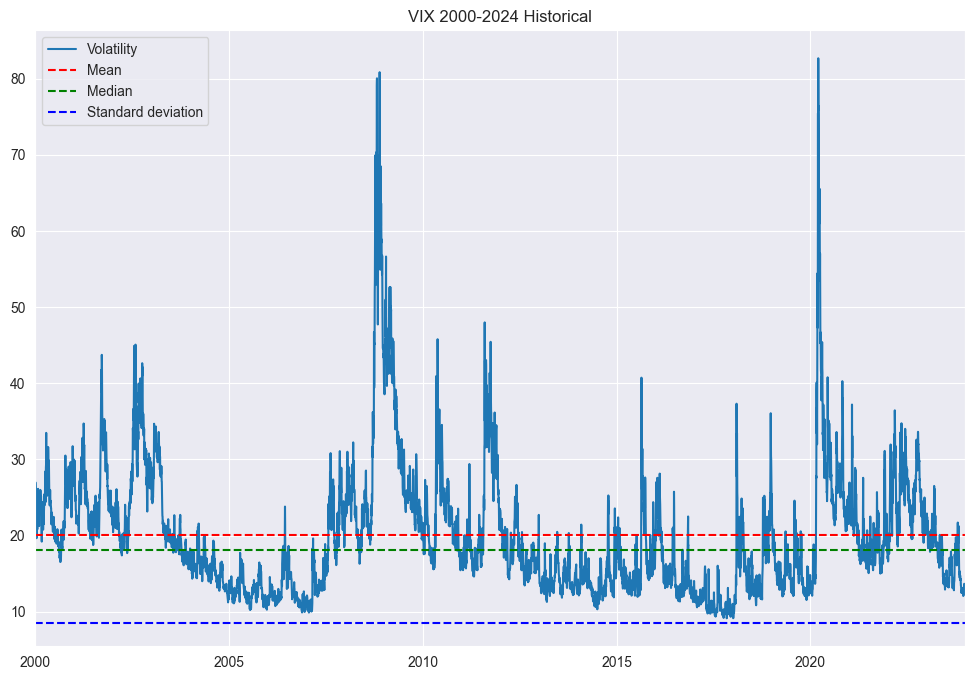

In [567]:
vix_plot = vix_data.plot(title='VIX 2000-2024 Historical', y='close', figsize=(12, 8), label='Volatility')

vix_mean = vix_data['close'].mean()
vix_median = vix_data['close'].median()
vix_std = vix_data['close'].std()

vix_plot.axhline(y=vix_mean, label='Mean', color='r', linestyle='dashed')
vix_plot.axhline(y=vix_median, label='Median', color='g', linestyle='dashed')
vix_plot.axhline(y=vix_std, label='Standard deviation', color='b', linestyle='dashed')

vix_plot.legend()

### US Bonds

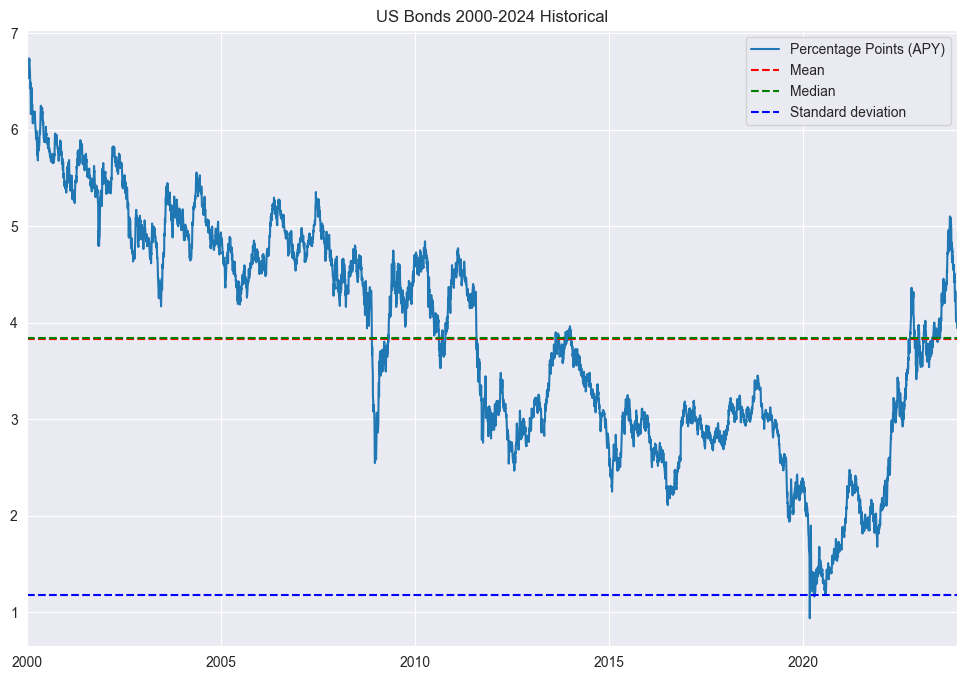

In [568]:
bonds_plot = bonds_data.plot(title='US Bonds 2000-2024 Historical', y='close',
                             label='Percentage Points (APY)', figsize=(12, 8))

bonds_mean = bonds_data['close'].mean()
bonds_median = bonds_data['close'].median()
bonds_std = bonds_data['close'].std()

bonds_plot.axhline(y=bonds_mean, label='Mean', color='r', linestyle='dashed')
bonds_plot.axhline(y=bonds_median, label='Median', color='g', linestyle='dashed')
bonds_plot.axhline(y=bonds_std, label='Standard deviation', color='b', linestyle='dashed')

bonds_plot.legend()

### Dow Jones Industrial Average

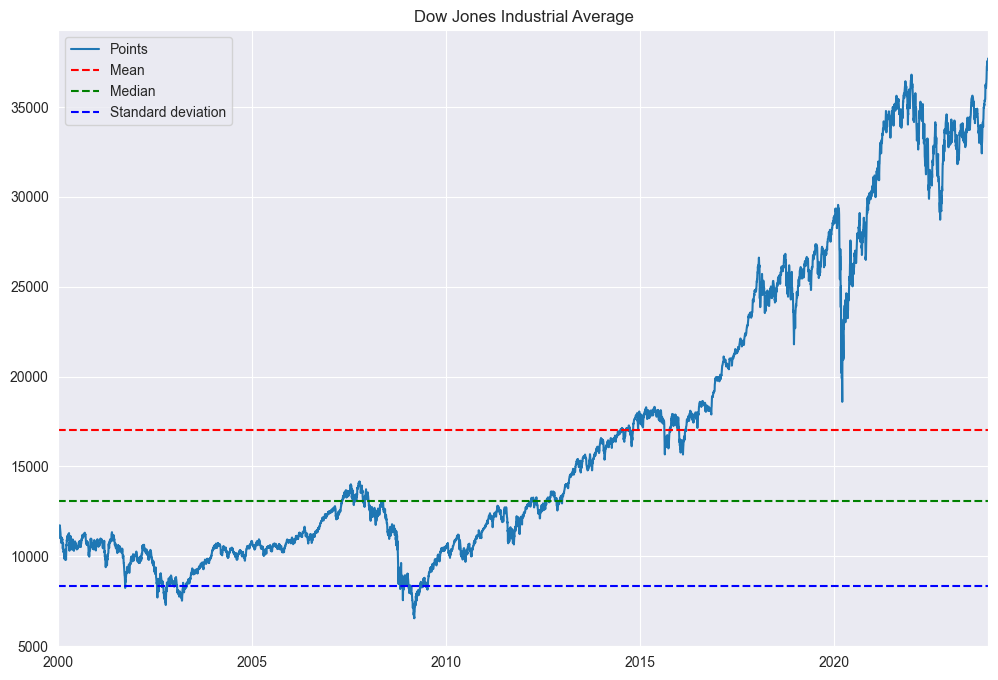

In [569]:
djia_plot = djia_data.plot(title='Dow Jones Industrial Average', y='close',
                             label='Points', figsize=(12, 8))

djia_mean = djia_data['close'].mean()
djia_median = djia_data['close'].median()
djia_std = djia_data['close'].std()

djia_plot.axhline(y=djia_mean, label='Mean', color='r', linestyle='dashed')
djia_plot.axhline(y=djia_median, label='Median', color='g', linestyle='dashed')
djia_plot.axhline(y=djia_std, label='Standard deviation', color='b', linestyle='dashed')

djia_plot.legend()

### Heatmap correlation matrix between S&P, VIX and US Bonds

Text(0.5, 1.0, 'Correlation matrix')

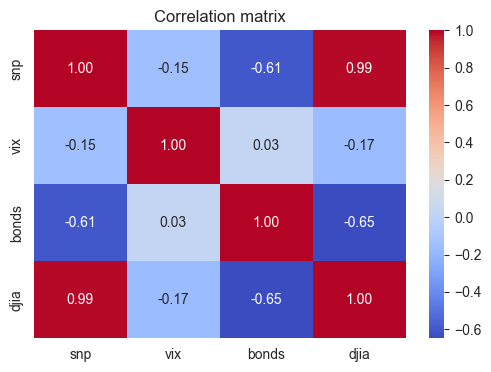

In [570]:
matrix_df = pd.DataFrame({
    'snp': snp_data['close'],
    'vix': vix_data['close'],
    'bonds': bonds_data['close'],
    'djia': djia_data['close']
})

corr_matrix_df = matrix_df.corr()

fig, ax = plt.subplots(figsize=(6, 4))

heatmap = sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
heatmap.set_title('Correlation matrix')

### Simple correlation between between S&P, VIX and US Bonds

Text(0.5, 1.0, 'Simple correlation')

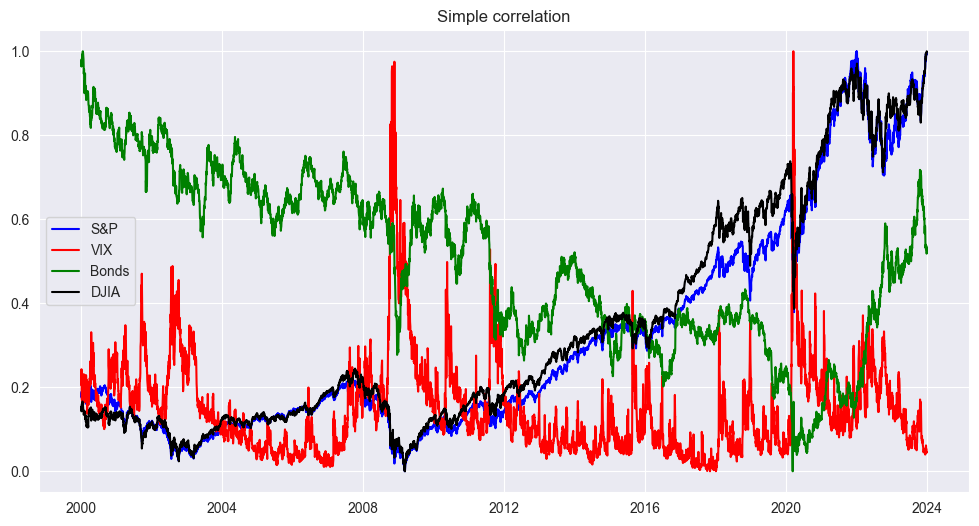

In [604]:
fig, ax = plt.subplots(figsize=(12, 6))

snp_norm = (snp_data['close'] - snp_data['close'].min()) / (snp_data['close'].max() - snp_data['close'].min())
vix_norm = (vix_data['close'] - vix_data['close'].min()) / (vix_data['close'].max() - vix_data['close'].min())
bonds_norm = (bonds_data['close'] - bonds_data['close'].min()) / (bonds_data['close'].max() - bonds_data['close'].min())
djia_norm = (djia_data['close'] - djia_data['close'].min()) / (djia_data['close'].max() - djia_data['close'].min())

ax.plot(snp_norm.index, snp_norm, color='b', label='S&P')
ax.plot(vix_norm.index, vix_norm, color='r', label='VIX')
ax.plot(bonds_norm.index, bonds_norm, color='g', label='Bonds')
ax.plot(djia_norm.index, djia_norm, color='black', label='DJIA')
ax.legend()
ax.set_title('Simple correlation')

### Data model synthesis with numpy Gaussian Distribution
#### Characteristics used:
- Mean
- Median
- Std

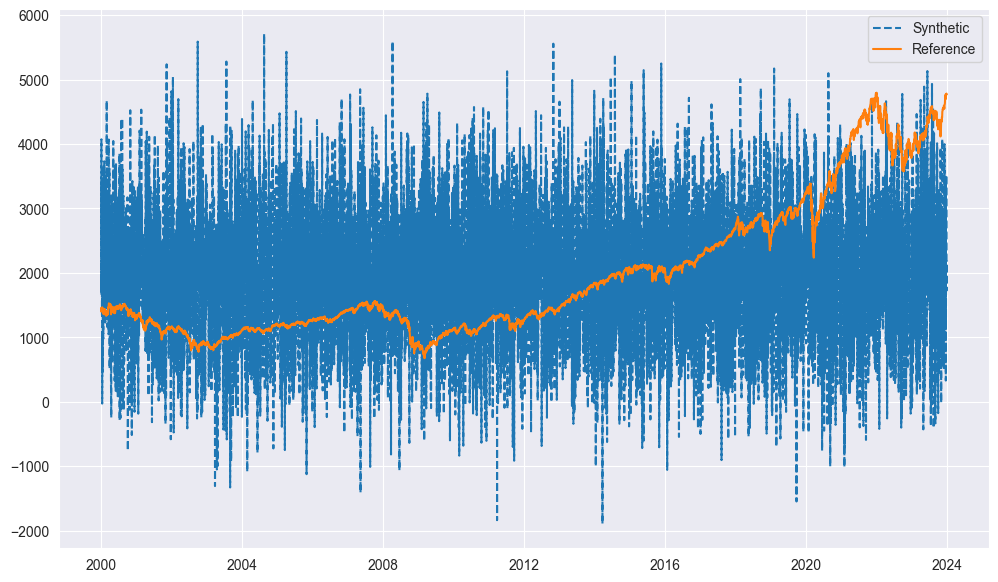

In [572]:
snp_synthetic = np.random.normal(loc=snp_mean, scale=snp_std, size=len(snp_data['close']))

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(snp_data.index, snp_synthetic, linestyle='--', label='Synthetic')
ax.plot(snp_data.index, snp_data['close'], label='Reference')
ax.legend()

### S&P 500 Decomposition

Text(0.5, 1.0, 'Residuals')

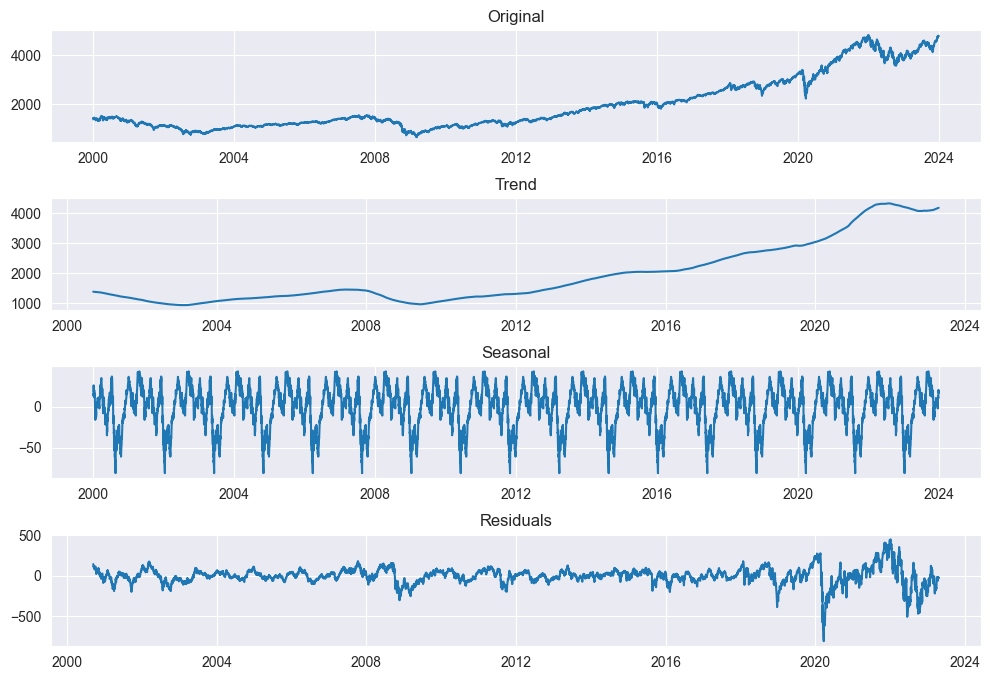

In [573]:
result = seasonal_decompose(snp_data['close'], model='additive', period=365)
fig, axs = plt.subplots(nrows=4, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
start_date_comp = start_date
end_date_comp = end_date

axs[0].plot(snp_data['close'][start_date_comp:end_date_comp], label='Original')
axs[0].set_title('Original')
axs[1].plot(result.trend[start_date_comp:end_date_comp], label='Trend')
axs[1].set_title('Trend')
axs[2].plot(result.seasonal[start_date_comp:end_date_comp], label='Seasonal')
axs[2].set_title('Seasonal')
axs[3].plot(result.resid[start_date_comp:end_date_comp], label='Residuals')
axs[3].set_title('Residuals')

### Stationary test (Dicker-Fuller)
- Null Hypothesis - if true (a = 1), the series is non-stationary
- Alternate Hypothesis - if ture, the series is stationary

Test Statistic:  1.4781644817965207 {'1%': -3.4314005857922973, '5%': -2.862004265452834, '10%': -2.567017125598209}
p-value:  0.9974418475474329
Lags used:  32
Observations used:  6227


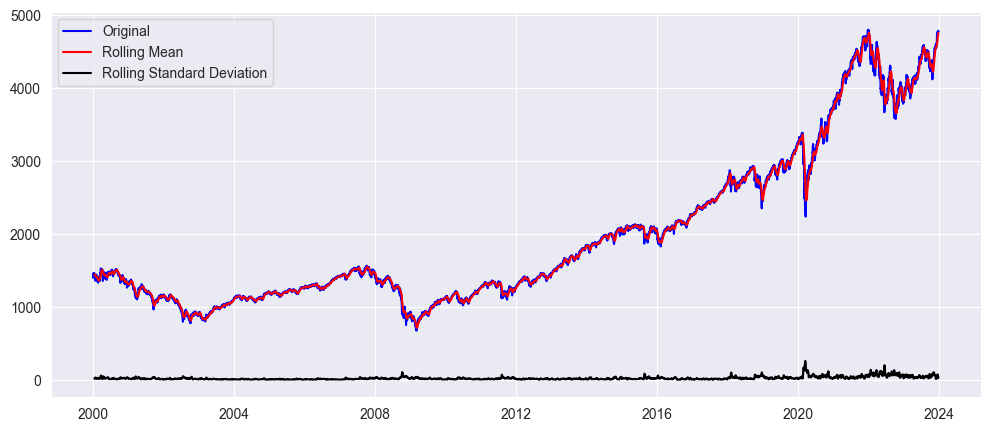

In [574]:
snp_rollmean = snp_data['close'].rolling(12).mean()
snp_rollstd = snp_data['close'].rolling(12).std()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(snp_data['close'], color='b', label='Original')
ax.plot(snp_rollmean, color='r', label='Rolling Mean')
ax.plot(snp_rollstd, color='black', label='Rolling Standard Deviation')
ax.legend()

# Augmented Dicker-Fuller Test
adft = adfuller(snp_data['close'], autolag='AIC')
print('Test Statistic: ', adft[0], adft[4])
# P-value tells us how likely the data would've appeared the way it did if null-hypothesis were true.
print('p-value: ', adft[1])
print('Lags used: ', adft[2])
print('Observations used: ', adft[3])

### Data model synthesis with ARIMA (Autoregressive Integrated Moving Average)

In [575]:
split_date = date_parser.parse(end_date) - relativedelta(years=1)
training_set = snp_data.loc[:split_date]
testing_set = snp_data.loc[split_date:]

diff_training_set = training_set['close'].diff().diff(365).dropna()
# Augmented Dicker-Fuller Test
adft = adfuller(diff_training_set, autolag='AIC')
# P-value tells us how likely the data would've appeared the way it did if null-hypothesis were true.
print('p-value: ', adft[1])

training_exogenous_df = pd.DataFrame({
    'bonds': bonds_data.loc[:split_date]['close'],
    'djia': djia_data.loc[:split_date]['close'],
    'vix': vix_data.loc[:split_date]['close'],
    'ds': training_set.index,
    'unique_id': 1
})
testing_exogenous_df = pd.DataFrame({
    'bonds': bonds_data.loc[split_date:]['close'],
    'djia': djia_data.loc[split_date:]['close'],
    'vix': vix_data.loc[split_date:]['close'],
    'ds': testing_set.index,
    'unique_id': 1
})
training_df = pd.DataFrame({
    # Note the diff here. We have to make dataset stationary
    'y': training_set['close'],
    'bonds': training_exogenous_df['bonds'],
    'djia': training_exogenous_df['djia'],
    'vix': training_exogenous_df['vix'],
    'ds': training_set.index,
    'unique_id': 1
})
testing_df = pd.DataFrame({
    'y': testing_set['close'],
    'bonds': testing_exogenous_df['bonds'],
    'djia': testing_exogenous_df['djia'],
    'vix': testing_exogenous_df['vix'],
    'ds': testing_set.index,
    'unique_id': 1
})

p-value:  5.2101510214614595e-27


In [585]:
arima_model = StatsForecast(
    models = [AutoARIMA(season_length=63)],
    freq=frequency,
    n_jobs=-1
)

arima_model = arima_model.fit(df=training_df)
print(arima_string(arima_model.fitted_[0, 0].model_))

steps = len(testing_df['y'])

snp_synthetic = arima_model.forecast(h=steps, X_df=testing_exogenous_df, level=[90])

Regression with ARIMA(0,1,0)(0,0,1)[63] errors


/Users/admin/Personal/Code/datascience-for-ek/.venv/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Users/admin/Personal/Code/datascience-for-ek/.venv/lib/python3.12/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


### Cumsum, stationary mean prediction (not used)

In [586]:
snp_synthetic

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
1,2023-01-02,3838.575684,3826.970459,3850.180664
1,2023-01-03,3837.758301,3821.346191,3854.170410
1,2023-01-04,3853.585449,3833.484863,3873.686035
1,2023-01-05,3815.516846,3792.306641,3838.727051
1,2023-01-06,3894.916016,3868.966309,3920.865723
...,...,...,...,...
1,2023-12-25,4319.596191,4131.106934,4508.085449
1,2023-12-26,4328.466797,4139.606445,4517.327637
1,2023-12-27,4342.404785,4153.173340,4531.635742


In [373]:
# snp_synthetic_cumsum = pd.Series([training_df.iloc[-1]['close']], pd.Series(snp_synthetic['mean'])).cumsum()

# last_s = pd.Series([training_set.iloc[-1]['close']])
# mean_s = pd.Series(snp_synthetic['mean'])
# snp_synthetic_cumsum = pd.concat([last_s, mean_s]).reset_index(drop=True).cumsum().drop(0)

# lo_conf_s = pd.concat([last_s, pd.Series(snp_synthetic['lo-90'])]).reset_index(drop=True).cumsum().drop(0)
# hi_conf_s = pd.concat([last_s, pd.Series(snp_synthetic['hi-90'])]).reset_index(drop=True).cumsum().drop(0)

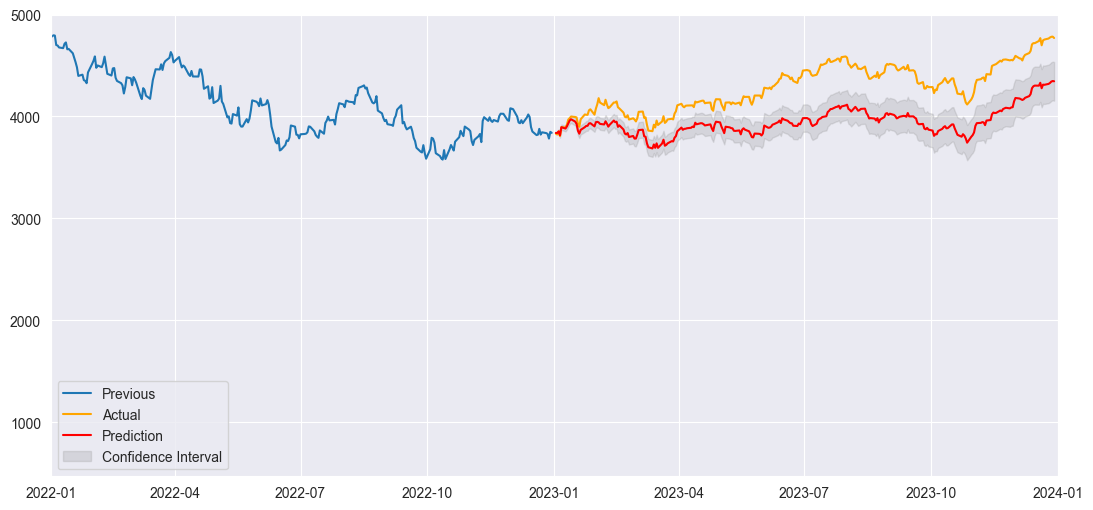

In [605]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.set_xlim(date_parser.parse('2022-01-01'), date_parser.parse('2024-01-01'))
ax.plot(training_set.index, training_set['close'], label='Previous')
ax.plot(testing_set.index, testing_set['close'], color='orange', label='Actual')
ax.plot(testing_set.index, snp_synthetic['AutoARIMA'], color='red', label='Prediction')
# ax.plot(testing_set.index[:steps], snp_synthetic.iloc[len(snp_synthetic['AutoARIMA']) - steps:]['AutoARIMA'], color='r', label='Predicted')
# ax.plot(testing_set.index[:steps], snp_synthetic['mean'], color='r', label='Predicted')
# ax.fill_between(testing_set.index[:steps], confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.2, label='Confidence Interval')
ax.fill_between(testing_set.index[:steps], snp_synthetic['AutoARIMA-lo-90'], snp_synthetic['AutoARIMA-hi-90'], color='gray', alpha=0.2,
                label='Confidence Interval')

ax.legend()

## Model error evaluation

In [602]:
from sklearn import metrics
import numpy as np

first_month_split_date = split_date + relativedelta(months=1) 

first_month_testing_df = testing_df.loc[split_date:first_month_split_date]
first_month_prediction = snp_synthetic.iloc[:len(first_month_testing_df)]

# Calculate errors
print(f'MAPE for entire prediction: {metrics.mean_absolute_percentage_error(testing_df['y'], snp_synthetic['AutoARIMA'])}')
print(f'MAPE for the first month: {metrics.mean_absolute_percentage_error(first_month_testing_df['y'], first_month_prediction['AutoARIMA'])}')

MAPE for entire prediction: 0.07734769667450656
MAPE for the first month: 0.016419636665385814
